# Log Regression on Linear Features

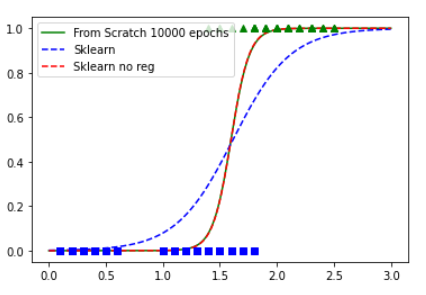* If we have linearly seperable data, even if we multiply weights by a high value, the solution remians same eg. w1x + w0 = 0, 1000w1x+ 1000 = 0
* Coefficients can go to infinity for linearly separable data. 



#### Iris Dataset
Lets make a classification with only one feature. We select petal width as it has a linear seperable decision boundary for class 0 and 1 as seen in the scatter plot below.


Note:
Sklearn has regularization by default. High C means lesser regularization

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import time
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_, score
from sklearn.preprocessing import PolynomialFeatures

In [4]:
class LogReg():

    def __init__(self,X,Y,alpha,epochs, C=1e10):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.epochs = epochs
        self.C = C

    def add_bias(self,X):
        X0 = np.ones((X.shape[0],1))
        X = np.concatenate((X0,X),axis=1)
        # print(f"Bias added {X.shape}")
        return X

    def init_weights(self):
        self.W = np.zeros((self.X.shape[1]))
        #return self.W

    def sigmoid(self,X):
        #Z = X@(self.W).T
        H = 1/(1+np.exp(-X))
        return H

    def calculate_cost(self):
        self.cost = -(self.Y.T@np.log(self.H)+(1-self.Y).T@np.log(1-self.H))/self.Y.shape[0]
        return self.cost
    
    def fit(self):
        self.X = self.add_bias(self.X)
        self.init_weights()
        #print(self.X.shape)
        for i in range(0,self.epochs):
            self.Z = self.X@(self.W).T
            self.H = self.sigmoid(self.Z)
            # grad = (self.H-self.Y).T@ self.X
            grad = (self.Y-self.H).T@ self.X
            self.W = self.W+(self.alpha)*(grad-2*self.W/self.C)
            if i%10000==0:
                pass
                #print(self.calculate_cost())
        return self.W
    
    def predict_proba(self,Xpred):
        Xpred = self.add_bias(Xpred)
        H = Xpred@(self.W).T
        pred = self.sigmoid(H)
        return pred#, 1-pred
    
    def predict(self,Xpred):
        pred = self.predict_proba(Xpred)
        return np.where(pred>0.5,1,0)



def get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test, visualize =False):
    lr_100 = LogReg(X_train,y_train,0.01,100)
    w_100 = lr_100.fit()
    prediction_100 = lr_100.predict(X_test)

    lr_10000 = LogReg(X_train,y_train,0.01,10000)
    w_10000 = lr_10000.fit()
    prediction_10000 = lr_10000.predict(X_test)

    sk_lr = LogisticRegression(fit_intercept = True)
    sk_lr.fit(X_train,y_train)
    sk_Pred = sk_lr.predict(X_test)

    sk_lr_no_C = LogisticRegression(fit_intercept = True, C = 1e15)
    sk_lr_no_C.fit(X_train,y_train)
    sk_Pred_no_C = sk_lr_no_C.predict(X_test)

    print("-------------------")
    print('Coefficients for my implementation 100 iterations')
    print(w_100)
    print('Coefficients for my implementation 10000 iterations')
    print(w_10000)
    print('Coefficients for sklearn')
    print(sk_lr.intercept_, sk_lr.coef_)
    print('Coefficients for sklearn no regularization')
    print(sk_lr_no_C.intercept_, sk_lr_no_C.coef_)
    print("-------------------")
    print('Confusion metrics for sklearn')
    print(metrics.confusion_matrix(sk_Pred,y_test))
    print('Confusion metrics for my implementation 10000 iterations')
    print(confusion_matrix(prediction_10000, y_test))
    print("-------------------")

    if visualize is True:
        X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
        y_proba_10000 = lr_10000.predict_proba(X_new)
        y_proba_sk = sk_lr.predict_proba(X_new)
        y_proba_sk_no_C = sk_lr_no_C.predict_proba(X_new)
        plt.plot(X_new, y_proba_10000, "g-")
        plt.plot(X_new, y_proba_sk[:,1], "b--")
        plt.plot(X_new, y_proba_sk_no_C[:,1], "r--")
        plt.plot(X[Y==0], Y[Y==0], "bs")
        plt.plot(X[Y==1], Y[Y==1], "g^")
        plt.legend(['From Scratch 10000 epochs', 'Sklearn', 'Sklearn no reg'])


def fit_and_draw_contour(X,y,degree=1, C= 1e20, implementation = 'sk', max_iter = 10000):
    poly = PolynomialFeatures(degree=degree,include_bias=False)

    X = poly.fit_transform(X)
    x0, x1 = np.meshgrid(
            np.linspace(0, 7, 500).reshape(-1, 1),
            np.linspace(0, 2.7, 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = poly.fit_transform(X_new)

    if implementation == 'scratch':
        log_reg = LogReg(X, y,0.01,20000,C=C)
        w_100 = log_reg.fit()
        #print(w_100)
        y_proba = log_reg.predict_proba(X_new)
        zz = y_proba.reshape(x0.shape)

    if implementation == 'sk':
        log_reg = LogisticRegression(solver="lbfgs",C=C, max_iter=max_iter, random_state=42)
        log_reg.fit(X, y)

        y_proba = log_reg.predict_proba(X_new)
        zz = y_proba[:, 1].reshape(x0.shape)

    plt.figure(figsize=(10, 4))
    plt.plot(X[y==0, 0], X[y==0, 1], "bs")
    plt.plot(X[y==1, 0], X[y==1, 1], "g^")


    contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


    # left_right = np.array([2.9, 7])
    # boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

    plt.clabel(contour, inline=1, fontsize=12)
    # plt.plot(left_right, boundary, "k--", linewidth=3)
    # plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
    # plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.axis([0, 7, 0, 2.7])
    #save_fig("logistic_regression_contour_plot")
    plt.show()

In [5]:
# Iris Dataset 
from sklearn import datasets
iris = datasets.load_iris()
Y = (iris["target"] == 0).astype(np.int) 
X = iris["data"][:, 3:] # petal width
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
df_iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

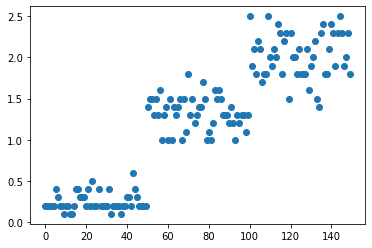

In [6]:
plt.scatter(np.arange(0,150), X)

-------------------
Coefficients for my implementation 100 iterations
[ 3.52039961 -5.04593791]
Coefficients for my implementation 10000 iterations
[ 12.3230329  -16.62172055]
Coefficients for sklearn
[3.16324308] [[-4.24155895]]
Coefficients for sklearn no regularization
[45.0423627] [[-56.4036589]]
-------------------
Confusion metrics for sklearn
[[20  0]
 [ 0 10]]
Confusion metrics for my implementation 10000 iterations
[[20  0]
 [ 0 10]]
-------------------


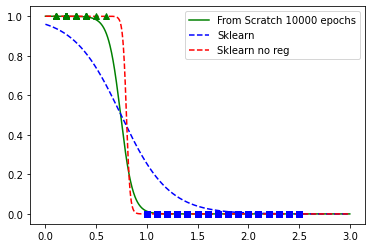

In [7]:
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test, visualize=True)

### Observations 

* Learned Probabilities:
    We get a steep sigmoid without regularization. Thus, the region where we are uncertain is small. So we are really confident at places where we can really go wrong. (seen clearly in the plot below)
* Coefficients go infinite:
    If we check the coefficient values in above case, as epoch increase my weights are increasing. Thus, there is a direct correlation between the magnitude of weight and the level of overfitting.   
<br>

### Reason

With MLE, we are trying to maximize our probabilty. So it will try to demarcate the classes as best as possible. So even for the data points very close to the boundary, probability ~0,1. But we would want the model to give us a low confidence score near the boundaries. This will ensure we dont overfit. For steeper sigmoid, even a very small change in x will can flip our decision which might not be preferable.

-------------------
Coefficients for my implementation 100 iterations
[-5.2864748   3.36969713]
Coefficients for my implementation 10000 iterations
[-19.80709489  12.39608287]
Coefficients for sklearn
[-6.43353134] [[3.98122058]]
Coefficients for sklearn no regularization
[-20.11358142] [[12.5896198]]
-------------------
Confusion metrics for sklearn
[[23  0]
 [ 1  6]]
Confusion metrics for my implementation 10000 iterations
[[22  0]
 [ 2  6]]
-------------------


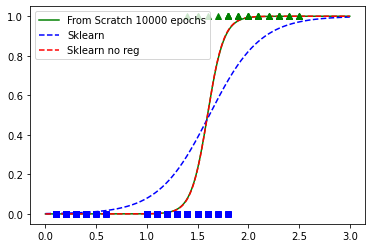

In [8]:
Y = (iris["target"] == 2).astype(np.int) 
X = iris["data"][:, 3:] # petal width
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=1)
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test,visualize=True)

# Log Regression on Polynomial Features 

### Iris with 2 features
The decision boundary is a line (so decision boundary is where $ypred = 0.5$. For one feature it was a point (x = w0/w1). For to featres it is w0 + w1x1+ w2x2 =0 which is a line. If we make x a polynomial it will be a hyperplane, shown later)


In [9]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 1).astype(np.int)

### Fit using different degree polynomial features

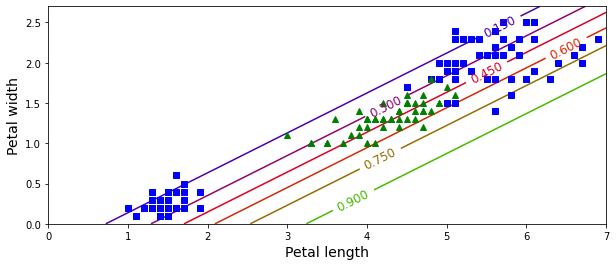

High bias model 
Cant linearly seperate the data


In [10]:
fit_and_draw_contour(X,y,degree = 1)

print('High bias model \nCant linearly seperate the data')

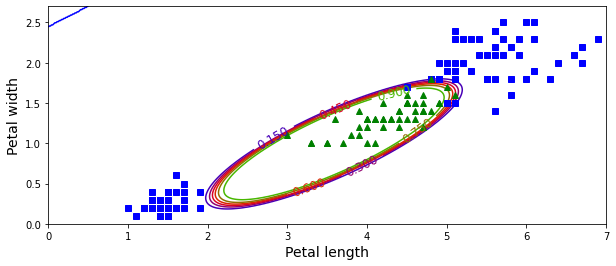

Good decision boundary
Narrow region of uncertainity


In [11]:
fit_and_draw_contour(X,y,degree = 2)

print('Good decision boundary\nNarrow region of uncertainity')

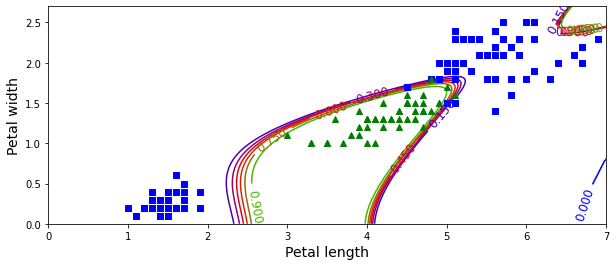

Complex decision boundary
Narrower region of uncertainity 


In [11]:
fit_and_draw_contour(X,y,degree = 5)
print('Complex decision boundary\nNarrower region of uncertainity ')

### L2 Regularization
To avoid overfiiting we need to add representation of magnitude of weight in our cost function in addition to the error. In L2 (Ridge) regularization we take L2 norm as given below:
$$ cost = \cal{L}(y,y^{\^}) + \frac{\lambda }{2}||W||^2_2 $$


Thus the GD update becomes:
$$ w = w + \alpha(\frac{\delta \cal{L}}{\delta \omega} -\lambda\omega)$$

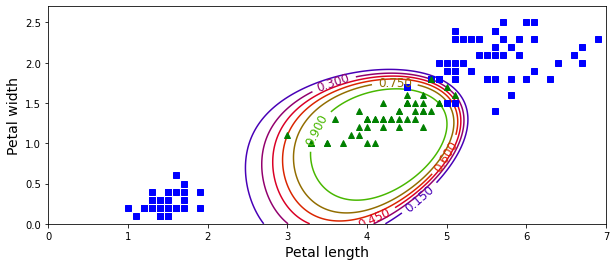

In [22]:
fit_and_draw_contour(X,y,degree = 5, C=0.01)